In [16]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import random

In [17]:
class EfficientVisionTransformer(nn.Module):

  def __init__(self, d_model=600, nhead=8, num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=2048, dropout=0.2, batch_first=True):


    super().__init__()
    # Patch embedding
    self.patch_embedding = nn.Conv2d(3, d_model, kernel_size=16, stride=16)

    # Efficient Transformer encoder
    encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first=True)
    self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_encoder_layers)

    # Decoder
    self.decoder = nn.Linear(d_model, 1)

  def forward(self, x):
    x = self.patch_embedding(x)
    x = x.flatten(2).transpose(1, 2)
    x = model.transformer_encoder(x)
    x = self.decoder(x.mean(dim=1))
    return x

In [18]:
class MinMaxScaler(nn.Module):
  def __init__(self, min_values, max_values):
    self.min_values = min_values
    self.max_values = max_values

  def __call__(self, data):
    return (data - self.min_values) / (self.max_values - self.min_values)

In [19]:
transform = transforms.Compose([
    transforms.Resize(600),
    transforms.ToTensor(),
    transforms.Normalize((0.2498, 0.3010, 0.1964), (0.1668, 0.1603, 0.1697)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    MinMaxScaler(1.8, 7.1)
])

In [20]:
# Define the custom dataset class
class ImageLabelDataset(Dataset):
    def __init__(self, image_dir, label_file, transform=None):
        self.image_dir = image_dir
        self.label_file = label_file
        self.transform = transform

        # Read labels from CSV file
        label_df = pd.read_csv(label_file)
        self.image_paths = label_df['image'].tolist()
        self.labels = label_df['FVC'].tolist()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = os.path.join(self.image_dir, self.image_paths[index])
        image = Image.open(image_path)
        label = self.labels[index]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

# Boundary value testing

In [29]:
# Function to generate synthetic boundary images
def generate_boundary_images(image_size):
    # Generate images with all pixels set to minimum and maximum values
    min_image = torch.zeros(image_size)
    max_image = torch.ones(image_size)
    min_image1 = torch.full(image_size, 1.8)
    max_image2 = torch.full(image_size, 7.1)

    # Generate images with alternating pixel patterns
    checkered_image = torch.full(image_size, 1.0)
    checkered_image[::2, ::2] = 7.1
    checkered_image[1::2, 1::2] = 7.1

    # Add more boundary cases as needed
    boundary_images = [min_image1, max_image2, checkered_image]
    return boundary_images

In [30]:
# Function to perform boundary value testing
def boundary_value_testing(model, boundary_images):
    # Set the model to evaluation mode
    model.eval()

    # Create a dummy input tensor for the forward pass
    dummy_input = torch.randn(1, 3, 600, 600)

    # Make predictions on boundary images
    with torch.no_grad():
        for image in boundary_images:
            image = image.unsqueeze(0)  # Add batch dimension
            prediction = model(image)
            print(f"Boundary Case: {image.squeeze().numpy()}")
            print(f"Prediction: {prediction.item()}")
            print("---")


In [31]:
# Load the trained model
model = EfficientVisionTransformer()
model = torch.load('/home/emmanuel/Project/model3.pt', map_location=torch.device('cpu'))
# ... (load the model weights, e.g., model.load_state_dict(torch.load('model.pth')))

# Generate boundary images
boundary_images = generate_boundary_images((3, 600, 600))

# Call the boundary value testing function
boundary_value_testing(model, boundary_images)

Boundary Case: [[[1.8 1.8 1.8 ... 1.8 1.8 1.8]
  [1.8 1.8 1.8 ... 1.8 1.8 1.8]
  [1.8 1.8 1.8 ... 1.8 1.8 1.8]
  ...
  [1.8 1.8 1.8 ... 1.8 1.8 1.8]
  [1.8 1.8 1.8 ... 1.8 1.8 1.8]
  [1.8 1.8 1.8 ... 1.8 1.8 1.8]]

 [[1.8 1.8 1.8 ... 1.8 1.8 1.8]
  [1.8 1.8 1.8 ... 1.8 1.8 1.8]
  [1.8 1.8 1.8 ... 1.8 1.8 1.8]
  ...
  [1.8 1.8 1.8 ... 1.8 1.8 1.8]
  [1.8 1.8 1.8 ... 1.8 1.8 1.8]
  [1.8 1.8 1.8 ... 1.8 1.8 1.8]]

 [[1.8 1.8 1.8 ... 1.8 1.8 1.8]
  [1.8 1.8 1.8 ... 1.8 1.8 1.8]
  [1.8 1.8 1.8 ... 1.8 1.8 1.8]
  ...
  [1.8 1.8 1.8 ... 1.8 1.8 1.8]
  [1.8 1.8 1.8 ... 1.8 1.8 1.8]
  [1.8 1.8 1.8 ... 1.8 1.8 1.8]]]
Prediction: -0.05743939429521561
---
Boundary Case: [[[7.1 7.1 7.1 ... 7.1 7.1 7.1]
  [7.1 7.1 7.1 ... 7.1 7.1 7.1]
  [7.1 7.1 7.1 ... 7.1 7.1 7.1]
  ...
  [7.1 7.1 7.1 ... 7.1 7.1 7.1]
  [7.1 7.1 7.1 ... 7.1 7.1 7.1]
  [7.1 7.1 7.1 ... 7.1 7.1 7.1]]

 [[7.1 7.1 7.1 ... 7.1 7.1 7.1]
  [7.1 7.1 7.1 ... 7.1 7.1 7.1]
  [7.1 7.1 7.1 ... 7.1 7.1 7.1]
  ...
  [7.1 7.1 7.1 ... 7.1 7.1 7.1]

In [20]:
prediction = -0.05737143009901047
output = (prediction - 0.5) * (7.0 - 1.0) + 1.0
output = output * 0.1656 + 0.2490
print(output)

-0.13920425294637678


# Regression Testing

In [6]:
# Load the trained model
model = EfficientVisionTransformer()
model = torch.load('/home/emmanuel/Project/model3.pt', map_location=torch.device('cpu'))
# ... (load the model weights, e.g., model.load_state_dict(torch.load('model.pth')))

In [7]:
# Define a regression test dataset
val_dataset = ImageLabelDataset('/home/emmanuel/Project/ImageDataset/Validation', '/home/emmanuel/Project/ImageDataset/Validation/validation.csv', transform=transform)
test_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [1]:
# Function to perform regression testing
def regression_testing(model, test_loader, expected_results):
    # Set the model to evaluation mode
    model.eval()

    # Iterate over the test dataset
    with torch.no_grad():
        for images, targets in test_loader:
            predictions = model(images)
            predictions = (predictions - 0.5) * (7.0 - 1.0) + 1.0
            predictions = predictions * 0.1656 + 0.2490

            # Compare predictions with expected results
            for i in range(len(predictions)):
                prediction = predictions[i].item()
                expected_result = expected_results[i]
                assert abs(prediction - expected_result) < 10e1, f"Regression detected for input {images[i].numpy()}"

    print("Regression testing passed")

In [31]:
# Load expected results for the test dataset
expected_results = [0.89,1,1,0.99,1,0.94,1,0.67,0.94,0.98,0.87,0.81,0.85,0.91,0.44,1,1,0.98,1,0.94,1,0.57,0.95,1,1,0.87,0.62,1,0.19,
1,1,1,0.9,0.36,0.9,0.33,1,1,1,0.99,0.86,1,0.16,1,1,0.96,0.99,1,0.97,0.04,0.99,1,1,1,1,1,0.1,0.93,1,0.78,1,1,1,0.09,0.73,0.84,0.68,0.95,
1,1,0,0.48,1,0.98,0.98,0.88,1,0,0.5,1,1,1,1,1,0.83,1,1,0.86,0.98,0.8,0.74,0.57,1,1,1,0.99,1,1,0.37,1,1,0.92,1,1,1,0.45,0.11,0.05,0.53,
0.99,0.99,0.95,0.46,0.62,0.26,0.38,0.97,0.89,1,1,0.57,0.94,0.94,1,0.66,0.79,0.93,1,0.69,0.96,0.97,0.77,0.84,1,0.87,0.06,0.85,0.71,0.91,
0.95,0.99,0.97,0.97,1,0.94,0.6,1,0.91,1,1,1,1,0.99,0.72,0.9,0.97,0.89,0.54,0.61,0.67,0.15,0.88,0.23,0.08,0.41,0.77,0.9,1,0.99,0.89,0.64,
0.41,0.51,0.63,1,1,0.94,0.93,0.31,0.01,0.02,0.6,0.93,0.85,0.93,0.98,0.71,0.48,0.57,0.99,0.87,0.99,0.94,0.75,0.92,0.87,1,1,1,0.81,1,0.63,
0.98,0.9,0.61,0.9,0.99,0.99,0.87,0.9,0.59,0.83,0.93,0.79,0.99,0.88,0.85,0.71,0.01,0.02,0.57,0.92,1,0.86,0.78,0.65,0.04,0.05,0.7,0.84,1,
0.94,0.88,0.71,0.63,0.4,0.72,0.72,1,0.92,0.71,0.66,0.22,0,0.2,0.74,0.92,0.91,0.75,0.91,0.01,0.01,0,0,0.46,0.05,0.78,0.04,0.04,0,0.08,
0.22,0.16,0.61,0.63,0.7,0.44,0.07,0.09,0.23,0.63,0.86,0.82,0.18,0.16,0.06,0.28,0.32,0.29,0.1,0.29,0.63,0.89]  # Replace with actual expected results

In [32]:
# Call the regression testing function
regression_testing(model, test_loader, expected_results)

AssertionError: Regression detected for input [[[-0.4580584  -0.50685394 -0.5379057  ... -0.49798203 -0.56895745
   -0.622189  ]
  [-0.46249434 -0.4846742  -0.4935461  ... -0.52016187 -0.55121356
   -0.58670133]
  [-0.4891101  -0.47136626 -0.4447505  ... -0.53346974 -0.5290338
   -0.52016187]
  ...
  [-0.5822653  -0.6000092  -0.6133171  ... -0.622189   -0.6133171
   -0.5955732 ]
  [-0.5733934  -0.58670133 -0.60444516 ... -0.622189   -0.622189
   -0.5822653 ]
  [-0.5645215  -0.57782936 -0.5955732  ... -0.622189   -0.622189
   -0.56895745]]

 [[-0.36618674 -0.4354243  -0.48158267 ... -0.38465008 -0.44927183
   -0.5092777 ]
  [-0.37541842 -0.4123451  -0.44004017 ... -0.3984976  -0.43080845
   -0.46311936]
  [-0.40311345 -0.40311345 -0.38926592 ... -0.4123451  -0.3938818
   -0.3938818 ]
  ...
  [-0.6108261  -0.62005776 -0.6339053  ... -0.62928945 -0.62005776
   -0.60159445]
  [-0.60159445 -0.6154419  -0.62467355 ... -0.6385211  -0.62005776
   -0.5877469 ]
  [-0.5923627  -0.60621023 -0.6154419  ... -0.643137   -0.6154419
   -0.5738994 ]]

 [[-0.3530606  -0.42718327 -0.50130594 ... -0.40102232 -0.475145
   -0.54926765]
  [-0.34870046 -0.3966622  -0.44462392 ... -0.41846296 -0.45770437
   -0.50566614]
  [-0.35742077 -0.37050125 -0.38794187 ... -0.42282313 -0.42718327
   -0.44026372]
  ...
  [-0.557988   -0.557988   -0.557988   ... -0.557988   -0.5449075
   -0.5274669 ]
  [-0.5536278  -0.557988   -0.557988   ... -0.557988   -0.557988
   -0.5143865 ]
  [-0.5536278  -0.557988   -0.557988   ... -0.557988   -0.5536278
   -0.50130594]]]

In [2]:
len(expected_results)

283

# Interpretability Testing

In [33]:
# Load the trained model
model = EfficientVisionTransformer()
model = torch.load('/home/emmanuel/Project/model3.pt', map_location=torch.device('cpu'))

In [34]:
# Define the path to your sample image (replace with your actual path)
image_path = "/home/emmanuel/Project/ImageDataset/Test/01_00000087.jpg_tile_5_6.jpg"

In [35]:
# Load the image using Pillow (PIL Fork)
img = transforms.ToTensor()(Image.open(image_path))

In [36]:
# Ensure the image has 3 channels (RGB) for compatibility with the model
if img.shape[0] != 3:
    raise ValueError("Image must have 3 channels (RGB).")

In [37]:
# Add a batch dimension (unsqueeze) for compatibility with the model
img = img.unsqueeze(0)  # Batch size of 1

In [38]:
print(f"Image loaded and converted to tensor. Shape: {img.shape}")

Image loaded and converted to tensor. Shape: torch.Size([1, 3, 600, 600])


In [39]:
# Forward pass
output = model(img)

In [40]:
# Basic interpretability checks:

# 1. Input shape compatibility
assert img.shape[1] == 3, "Input image must have 3 channels (RGB)"

In [41]:
# 2. Output shape (assuming regression for simplicity)
assert output.shape[1] == 1, "Model output should have 1 dimension for regression"

In [42]:
# 3. Gradient check (optional, for rudimentary sanity check)
output.backward()  # Calculate gradients
for name, param in model.named_parameters():
    if param.grad is not None:
        print(f"Parameter: {name}, Gradient mean: {param.grad.mean().item()}")
print("Interpretability checks passed (basic)!")

Parameter: patch_embedding.weight, Gradient mean: -3.333434142405167e-05
Parameter: patch_embedding.bias, Gradient mean: -0.00018543006444815546
Parameter: transformer_encoder.layers.0.self_attn.in_proj_weight, Gradient mean: -4.6150935872901755e-07
Parameter: transformer_encoder.layers.0.self_attn.in_proj_bias, Gradient mean: 0.00020311609841883183
Parameter: transformer_encoder.layers.0.self_attn.out_proj.bias, Gradient mean: -1.9868215406226852e-10
Parameter: transformer_encoder.layers.0.linear1.bias, Gradient mean: -0.0001544733386253938
Parameter: transformer_encoder.layers.0.linear1.weight_orig, Gradient mean: 2.6261453456299932e-08
Parameter: transformer_encoder.layers.0.linear2.bias, Gradient mean: -4.46258741765293e-12
Parameter: transformer_encoder.layers.0.linear2.weight_orig, Gradient mean: -2.4461533243425038e-08
Parameter: transformer_encoder.layers.0.norm1.weight, Gradient mean: -4.359465037850896e-06
Parameter: transformer_encoder.layers.0.norm1.bias, Gradient mean: -2.

## Interpretabilty Explainer

In [43]:
def predict(prediction):
    output = (prediction - 0.5) * (7.0 - 1.0) + 1.0
    output = output * 0.1656 + 0.2490
    return output

In [44]:
# Forward pass to get output probabilities
# Define the path to your sample image (replace with your actual path)
image_path = "/home/emmanuel/Project/ImageDataset/Test/01_00000087.jpg_tile_5_6.jpg"
img = Image.open(image_path)

In [45]:
def preprocess_image(image):
    # Assuming image is a tensor with shape (channels, height, width)
    mean = torch.tensor([0.2498, 0.3010, 0.1964])  # Replace with appropriate mean values if needed
    std = torch.tensor([0.1668, 0.1603, 0.1697])  # Replace with appropriate std values if needed
    image = image.permute(1, 2, 0)  # Move channel dimension to last if necessary
    image = (image - mean) / std  # Normalize based on mean and standard deviation
    return image 

In [46]:
def visualize_images(original_image, perturbed_image, title="Original vs. Perturbed Image"):
    fig, (ax1, ax2) = plt.subplots(1, 2)

    # Assuming original_image and perturbed_image are preprocessed tensors
    #original_image = original_image.squeeze()  # Move channel dimension to last
    #perturbed_image = perturbed_image.squeeze()

    original_image = original_image.squeeze() * 255  # Assuming uint8 image
    perturbed_image = perturbed_image.squeeze()* 255  # Assuming uint8 image
    original_image = torch.clamp(original_image, 0, 255)  # Clip values to 0-255
    perturbed_image = torch.clamp(perturbed_image, 0, 255)  # Clip values to 0-255
    original_image = original_image.to(torch.uint8)  # Convert to uint8 for proper display
    perturbed_image = perturbed_image.to(torch.uint8)  # Convert to uint8 for proper display

    ax1.imshow(original_image)
    ax1.set_title("Original Image")
    ax1.axis('off')

    ax2.imshow(perturbed_image)
    ax2.set_title("Perturbed Image")
    ax2.axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [47]:
# Define perturbation function (replace with your desired modifications)
def perturb(image, mask_size=32):
    mask = torch.zeros_like(image[0])
    mask.random_(0, 255)
    mask[:, mask_size // 2:-mask_size // 2, mask_size // 2:-mask_size // 2] = 255  # Apply mask to a central region
    return image + mask

In [48]:
img = transform(img)

In [49]:
# Create a copy of the image for perturbation
perturbed_image = img.clone()

In [50]:
# Perturb the image and get predictions
perturbed_output = model(perturb(perturbed_image.unsqueeze(0)))
original_prediction = model(img.unsqueeze(0))

In [51]:
# Extract prediction values from tensors (assuming they're single-valued)
original_prediction = original_prediction.item()
perturbed_prediction = perturbed_output.item()

In [52]:
# Preprocess images for visualization (adjust based on your preprocessing steps)
original_image_vis = preprocess_image(img.clone())
perturbed_image_vis = preprocess_image(perturbed_image.clone())

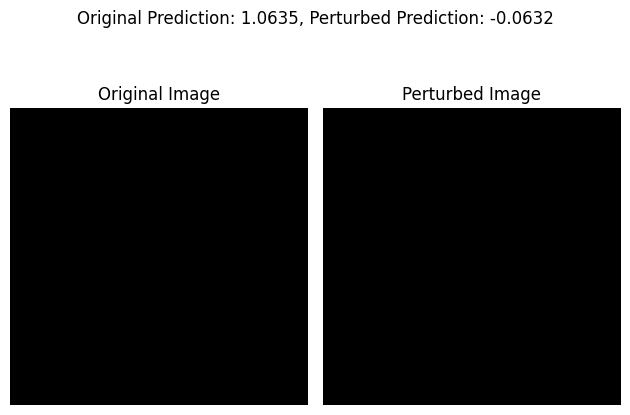

In [53]:
# Visualize the original image and the perturbed image with formatted predictions
visualize_images(original_image_vis, perturbed_image_vis, title=f"Original Prediction: {original_prediction:.4f}, Perturbed Prediction: {perturbed_prediction:.4f}")

In [55]:
transformed_original = predict(original_prediction)
transformed_perturbed = predict(perturbed_prediction)

In [56]:
print(transformed_original, transformed_perturbed)

0.974510347366333 -0.14501840672492983
